In [1]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

<module 'data_loading' from '../../data_loading.py'>

In [2]:
reload(dl)
dl.get_pot_trig(1, "runs", "bnb")

(1.67e+20, 37094101)

In [3]:
reload(dl)
RUN = 1
rundata = dl.load_run(
    RUN,
    "bnb",
    truth_filtered_sets=["nue"],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
)

../../data_loading.py:1015: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1015: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:534: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:534: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:697: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot /

In [11]:
# remove all nue events from the "mc" dataset, since we already loaded them into the "nue" dataset

rundata["mc"].query("abs(nu_pdg) != 12", inplace=True)

In [12]:
import pandas as pd
for k, df in rundata.items():
    df["label"] = k
    df["label"] = df["label"].astype("category")
# make one dataframe for all events except for "data"
df = pd.concat([df for k, df in rundata.items() if k != "data"])
df_bnb = rundata["data"]

In [13]:
from unblinding_far_sideband import selection_categories, basic_variables, preselection_categories

Data bin counts: [ 0  3 16  6  7  4  2  5  0  1  0  2  0  0  0  1  2]
MC variance: [0.00000000e+00 1.85089453e+00 2.69793596e+00 8.21170380e-01
 1.07316893e+00 2.00721755e-01 2.88476162e-01 3.62474763e-01
 4.71777470e-02 4.59175475e-02 1.31305796e-02 2.28754546e-02
 2.21768366e-02 5.66613301e-03 2.10953333e-02 1.62240250e-03
 1.92567308e-02]
MC bin counts: [ 0.          6.52154713 14.14956321  8.66837211  7.80506034  4.2463167
  4.77038722  3.13455804  1.9177893   1.788764    1.4763525   1.01623329
  0.90807254  0.54712244  0.64833617  0.29450391  0.49367102]


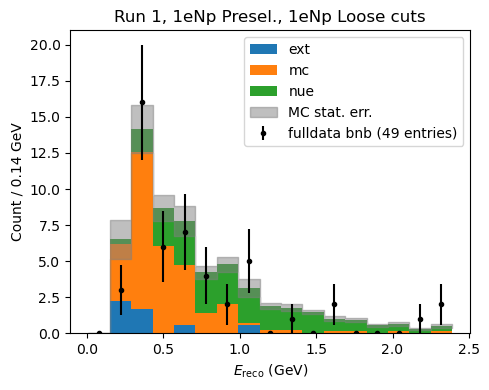

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


VARIABLE, BINS, RANGE, XTIT = "reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]"
labels = df["label"].unique()

selection = "NPL"
preselection = "NP"

presel_query = preselection_categories[preselection]["query"]
presel_title = preselection_categories[preselection]["title"]

sel_query = selection_categories[selection]["query"]
sel_title = selection_categories[selection]["title"]

if presel_query is None:
    query = sel_query
    presel_title = "No Presel."
elif sel_query is None:
    query = presel_query
    sel_title = "No Sel."
else:
    query = f"{presel_query} and {sel_query}"

fig, ax = plt.subplots(figsize=(5, 4))

bnb_filtered = df_bnb.query(query)

# Plot the beam-on data (bnb) on top as points with error bars
hist, bin_edges = np.histogram(bnb_filtered[VARIABLE], bins=BINS, range=RANGE)
hist_err = np.sqrt(hist)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.0
bin_width = (bin_edges[1:] - bin_edges[:-1])[0]
entries = np.sum(hist)
ax.errorbar(bin_centers, hist, yerr=hist_err, fmt=".", color="black", label=f"fulldata bnb ({entries:.0f} entries)")

print(f"Data bin counts: {hist}")

# Plot the MC as a stacked histogram
data = [df.query(query).loc[df.query(query)["label"] == lbl, VARIABLE] for lbl in labels]
weights = [df.query(query).loc[df.query(query)["label"] == lbl, "weights"] for lbl in labels]

ax.hist(data, bins=BINS, range=RANGE, stacked=True, label=labels, weights=weights)

# Calculate the total statistical MC error in each bin and plot it as a shaded region.
# Use the sum of squared weights in each bin as the variance. We want to sum over all
# of the stacked histograms.
hist_mc_var, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights) ** 2)
hist_mc_err = np.sqrt(hist_mc_var)
print(f"MC variance: {hist_mc_var}")
hist_mc_tot, _ = np.histogram(np.concatenate(data), bins=BINS, range=RANGE, weights=np.concatenate(weights))
print(f"MC bin counts: {hist_mc_tot}")
mc_err_lo = hist_mc_tot - hist_mc_err
mc_err_hi = hist_mc_tot + hist_mc_err
ax.fill_between(
    bin_edges,
    np.append(mc_err_lo, mc_err_lo[-1]),
    np.append(mc_err_hi, mc_err_hi[-1]),
    step="post",
    color="gray",
    alpha=0.5,
    label="MC stat. err.",
)

ax.legend()

ax.set_xlabel(r"$E_\mathrm{reco}$ (GeV)")
ax.set_ylabel(f"Count / {bin_width:.2f} GeV")
ax.set_title(f"Run {RUN}, {presel_title}, {sel_title}")

fig.tight_layout()

# fig.savefig(f"run{RUN}_{presel_title.replace(' ', '_').lower()}_{sel_title.replace(' ', '_').lower()}.pdf")
# old code MC total before bugfix: [ 0.     6.522 13.878  8.662  7.667  4.226  4.766  3.128  1.914  1.776
#   1.476  1.015  0.898  0.547  0.648  0.295  0.49 ]
# old code MC total after energy bugfix: [ 0.          6.52188317 14.1495637   8.92651525  7.81142247  4.25267874
#   4.77851279  3.13773905  1.91778935  1.79247478  1.47953348  1.01941426
#   0.91125443  0.54712246  0.64833618  0.29768487  0.49367103]
# old code MC total after setting trk_pid to NaN instead of 9999:
# [ 0.          6.52188317 14.1495637   8.92651525  7.81142247  4.25267874
#   4.77851279  3.13773905  1.91778935  1.79247478  1.47953348  1.01941426
#   0.91125443  0.54712246  0.64833618  0.29768487  0.49367103]
# old code MC nu variance:
# [0.    0.564 1.725 0.837 0.73  0.179 0.265 0.016 0.033 0.033 0.    0.016
#  0.016 0.    0.016 0.    0.016]
# old code MC nue variance: 
# [0.    0.003 0.01  0.016 0.023 0.022 0.024 0.025 0.015 0.013 0.013 0.007
#  0.006 0.006 0.005 0.002 0.003]
# old code error ext:
# [0.629 1.284 0.963 0.629 0.321 0.629 0.629 0.321 0.629 0.629 0.629 0.629
#  0.629 0.629 0.629 0.629 0.629]

In [209]:
from plotting import histogram
reload(histogram)

VARIABLE, BINS, RANGE, XTIT = "reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]"
labels = df["label"].unique()

selection = "NPL"
preselection = "NP"

presel_query = preselection_categories[preselection]["query"]
presel_title = preselection_categories[preselection]["title"]

sel_query = selection_categories[selection]["query"]
sel_title = selection_categories[selection]["title"]

if presel_query is None:
    query = sel_query
    presel_title = "No Presel."
elif sel_query is None:
    query = presel_query
    sel_title = "No Sel."
else:
    query = f"{presel_query} and {sel_query}"


bin_edges = np.linspace(*RANGE, BINS+1)

hist_gen = histogram.HistogramGenerator(df, "weights", VARIABLE, bin_edges, query=query)

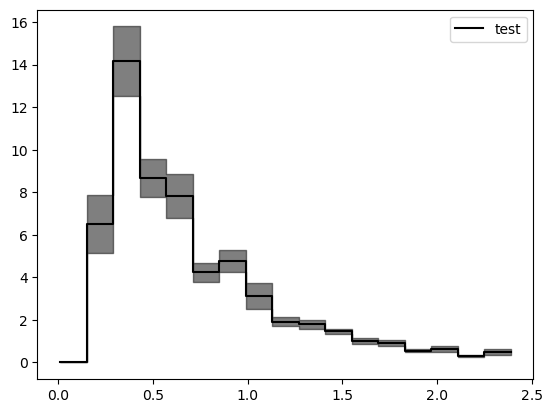

In [222]:
from plotting import histogram
reload(histogram)

hist = hist_gen.generate()
hist.label = "test"


def plot_hist(
    hist, ax=None, show_errorband=True, as_errorbars=False, uncertainty_color=None, uncertainty_label=None, **kwargs
):
    """Plot a histogram with uncertainties."""

    if ax is None:
        ax = plt.gca()
    # make a step plot of the histogram
    bin_counts = hist.nominal_values
    bin_edges = hist.bin_edges
    if "label" in kwargs:
        label = kwargs.pop("label")
    else:
        label = hist.tex_string
    if as_errorbars:
        ax.errorbar(
            hist.bin_centers, bin_counts, yerr=hist.std_devs, linestyle="none", marker=".", label=label, **kwargs
        )
        return ax
    # Be sure to repeat the last bin count
    bin_counts = np.append(bin_counts, bin_counts[-1])
    p = ax.step(bin_edges, bin_counts, where="post", label=label, **kwargs)
    if not show_errorband:
        return ax
    # plot uncertainties as a shaded region
    uncertainties = hist.std_devs
    uncertainties = np.append(uncertainties, uncertainties[-1])
    # ensure that error band has the same color as the plot we made earlier unless otherwise specified
    if uncertainty_color is None:
        kwargs["color"] = p[0].get_color()
    else:
        kwargs["color"] = uncertainty_color

    ax.fill_between(
        bin_edges,
        bin_counts - uncertainties,
        bin_counts + uncertainties,
        alpha=0.5,
        step="post",
        label=uncertainty_label,
        **kwargs
    )

    return ax


def plot_stacked_hists(hists, ax=None, show_errorband=True, uncertainty_color=None, uncertainty_label=None, **kwargs):
    """Plot a stack of histograms."""
    if ax is None:
        ax = plt.gca()

    x = hists[0].bin_edges
    def repeated_nom_values(hist):
        # repeat the last bin count
        y = hist.nominal_values
        y = np.append(y, y[-1])
        return y
    # to use plt.stackplot,  we need y to be a 2D array of shape (N, len(x))
    y = np.array([repeated_nom_values(hist) for hist in hists])
    labels = [hist.tex_string for hist in hists]
    colors = None
    # If all hist.color are not None, we can pass them to stackplot
    if all([hist.color is not None for hist in hists]):
        colors = [hist.color for hist in hists]

    ax.stackplot(x, y, step="post", labels=labels, colors=colors, **kwargs)
    if not show_errorband:
        return ax
    # plot uncertainties as a shaded region, but only for the sum of all hists
    summed_hist = sum(hists)
    # show sum as black line
    p = ax.step(summed_hist.bin_edges, repeated_nom_values(summed_hist), where="post", color="k", lw=0.5)
    # show uncertainty as shaded region
    uncertainties = summed_hist.std_devs
    uncertainties = np.append(uncertainties, uncertainties[-1])
    # ensure that error band has the same color as the plot we made earlier unless otherwise specified
    if uncertainty_color is None:
        kwargs["color"] = p[0].get_color()
    else:
        kwargs["color"] = uncertainty_color
    ax.fill_between(
        summed_hist.bin_edges,
        repeated_nom_values(summed_hist) - uncertainties,
        repeated_nom_values(summed_hist) + uncertainties,
        alpha=0.6,
        step="post",
        label=uncertainty_label,
        **kwargs
    )
    return ax


ax = plot_hist(hist, as_errorbars=False, color="k")
ax.legend()

In [223]:
from plotting import histogram
reload(histogram)

VARIABLE, BINS, RANGE, XTIT = "reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]"
labels = df["label"].unique()

selection = "NPL"
preselection = "NP"

presel_query = preselection_categories[preselection]["query"]
presel_title = preselection_categories[preselection]["title"]

sel_query = selection_categories[selection]["query"]
sel_title = selection_categories[selection]["title"]

if presel_query is None:
    query = sel_query
    presel_title = "No Presel."
elif sel_query is None:
    query = presel_query
    sel_title = "No Sel."
else:
    query = f"{presel_query} and {sel_query}"


bin_edges = np.linspace(*RANGE, BINS+1)

run_hist_gen = histogram.RunHistGenerator(rundata, variable=VARIABLE, binning=bin_edges, query=query)

In [224]:
data_hist = run_hist_gen.get_data_hist()

In [225]:
ext_hist = run_hist_gen.get_data_hist(type='ext')
ext_hist.label = "EXT"

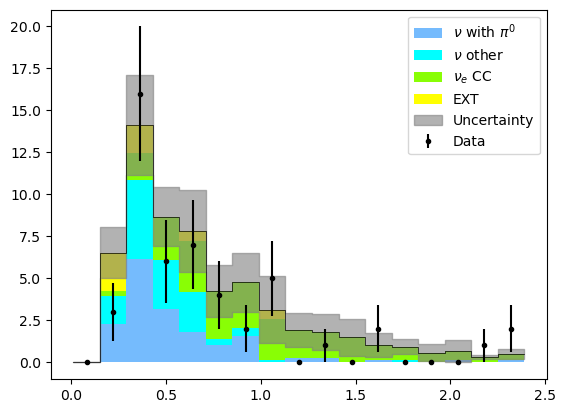

In [230]:
from plotting import histogram
reload(histogram)

mc_hists = run_hist_gen.get_mc_hists(include_multisim_errors=True, category_column="paper_category")
pred_hists =  list(mc_hists.values()) + [ext_hist]
ax = plot_stacked_hists(pred_hists, uncertainty_color="gray", uncertainty_label="Uncertainty")
plot_hist(data_hist, ax=ax, label="Data", color="black", as_errorbars=True)
ax.legend(loc="upper right")

In [122]:
mc_hists.keys()

dict_keys(['mc', 'nue'])

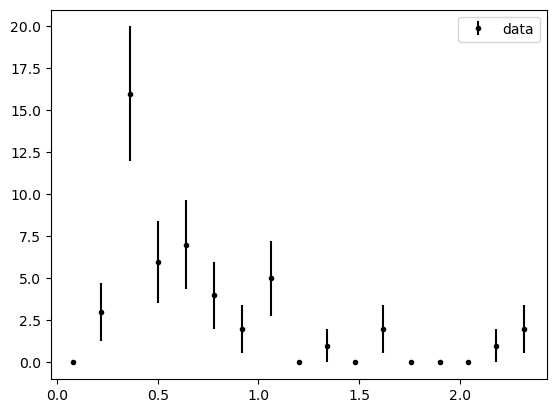

In [120]:
ax = plot_hist(data_hist, as_errorbars=True, color="k")
ax.legend()

In [5]:
import sys
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from plotting import run_plotter as rp

In [18]:
reload(dl)
RUN = 1
rundata, *_ = dl.load_run(
    RUN,
    "bnb",
    truth_filtered_sets=[],
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
)

../../data_loading.py:1015: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1015: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:534: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:534: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:697: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, 

In [27]:
reload(rp)

selection = "NPL"
preselection = "NP"

plotter = rp.Plotter(rundata, selection, preselection, variable="reco_e", weight_column="weights")

{}


<AxesSubplot:title={'center':'1eNp Presel. and 1eNp Loose cuts'}, xlabel='Reconstructed Energy [ GeV ]', ylabel='Events'>

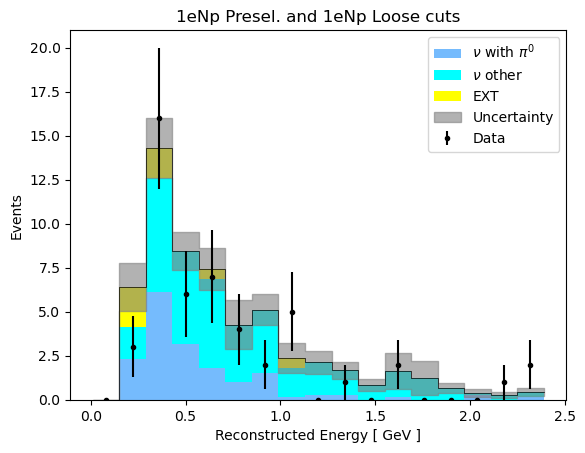

In [28]:
plotter.plot(category_column="paper_category")